# Regression Problem: Forest Fires dataset

In [1]:
import os, sys
import re
import pandas as pd
from scipy import stats
import numpy as np

import urllib.request
import json

import matplotlib.pyplot as plt
import seaborn as sns
# all the scikit-learn libraries

from sklearn.preprocessing import scale, LabelEncoder
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import label_binarize, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import scale, StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from patsy import dmatrix

%matplotlib inline
plt.style.use('ggplot')

/Users/User/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### LOAD THE DATASET :
#### *We import urllib.request to load the dataset dynamically from the repository, instead of having to save it/ downloading it prior to running the notebook*

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv'

In [3]:
raw_firedata = urllib.request.urlopen(url)

In [4]:
fire_dataset = raw_firedata.read().decode('utf-8')
with open('forestfires.csv', 'w+') as f:
    f.write(fire_dataset)
f.close()    

### Dataset Visualization

In [5]:
fire_df = pd.read_csv('forestfires.csv', na_values='?').dropna()
fire_df.head(7)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0
5,8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0.0
6,8,6,aug,mon,92.3,88.9,495.6,8.5,24.1,27,3.1,0.0,0.0


In [6]:
fire_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 517 entries, 0 to 516
Data columns (total 13 columns):
X        517 non-null int64
Y        517 non-null int64
month    517 non-null object
day      517 non-null object
FFMC     517 non-null float64
DMC      517 non-null float64
DC       517 non-null float64
ISI      517 non-null float64
temp     517 non-null float64
RH       517 non-null int64
wind     517 non-null float64
rain     517 non-null float64
area     517 non-null float64
dtypes: float64(8), int64(3), object(2)
memory usage: 56.5+ KB


In [7]:
fire_df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


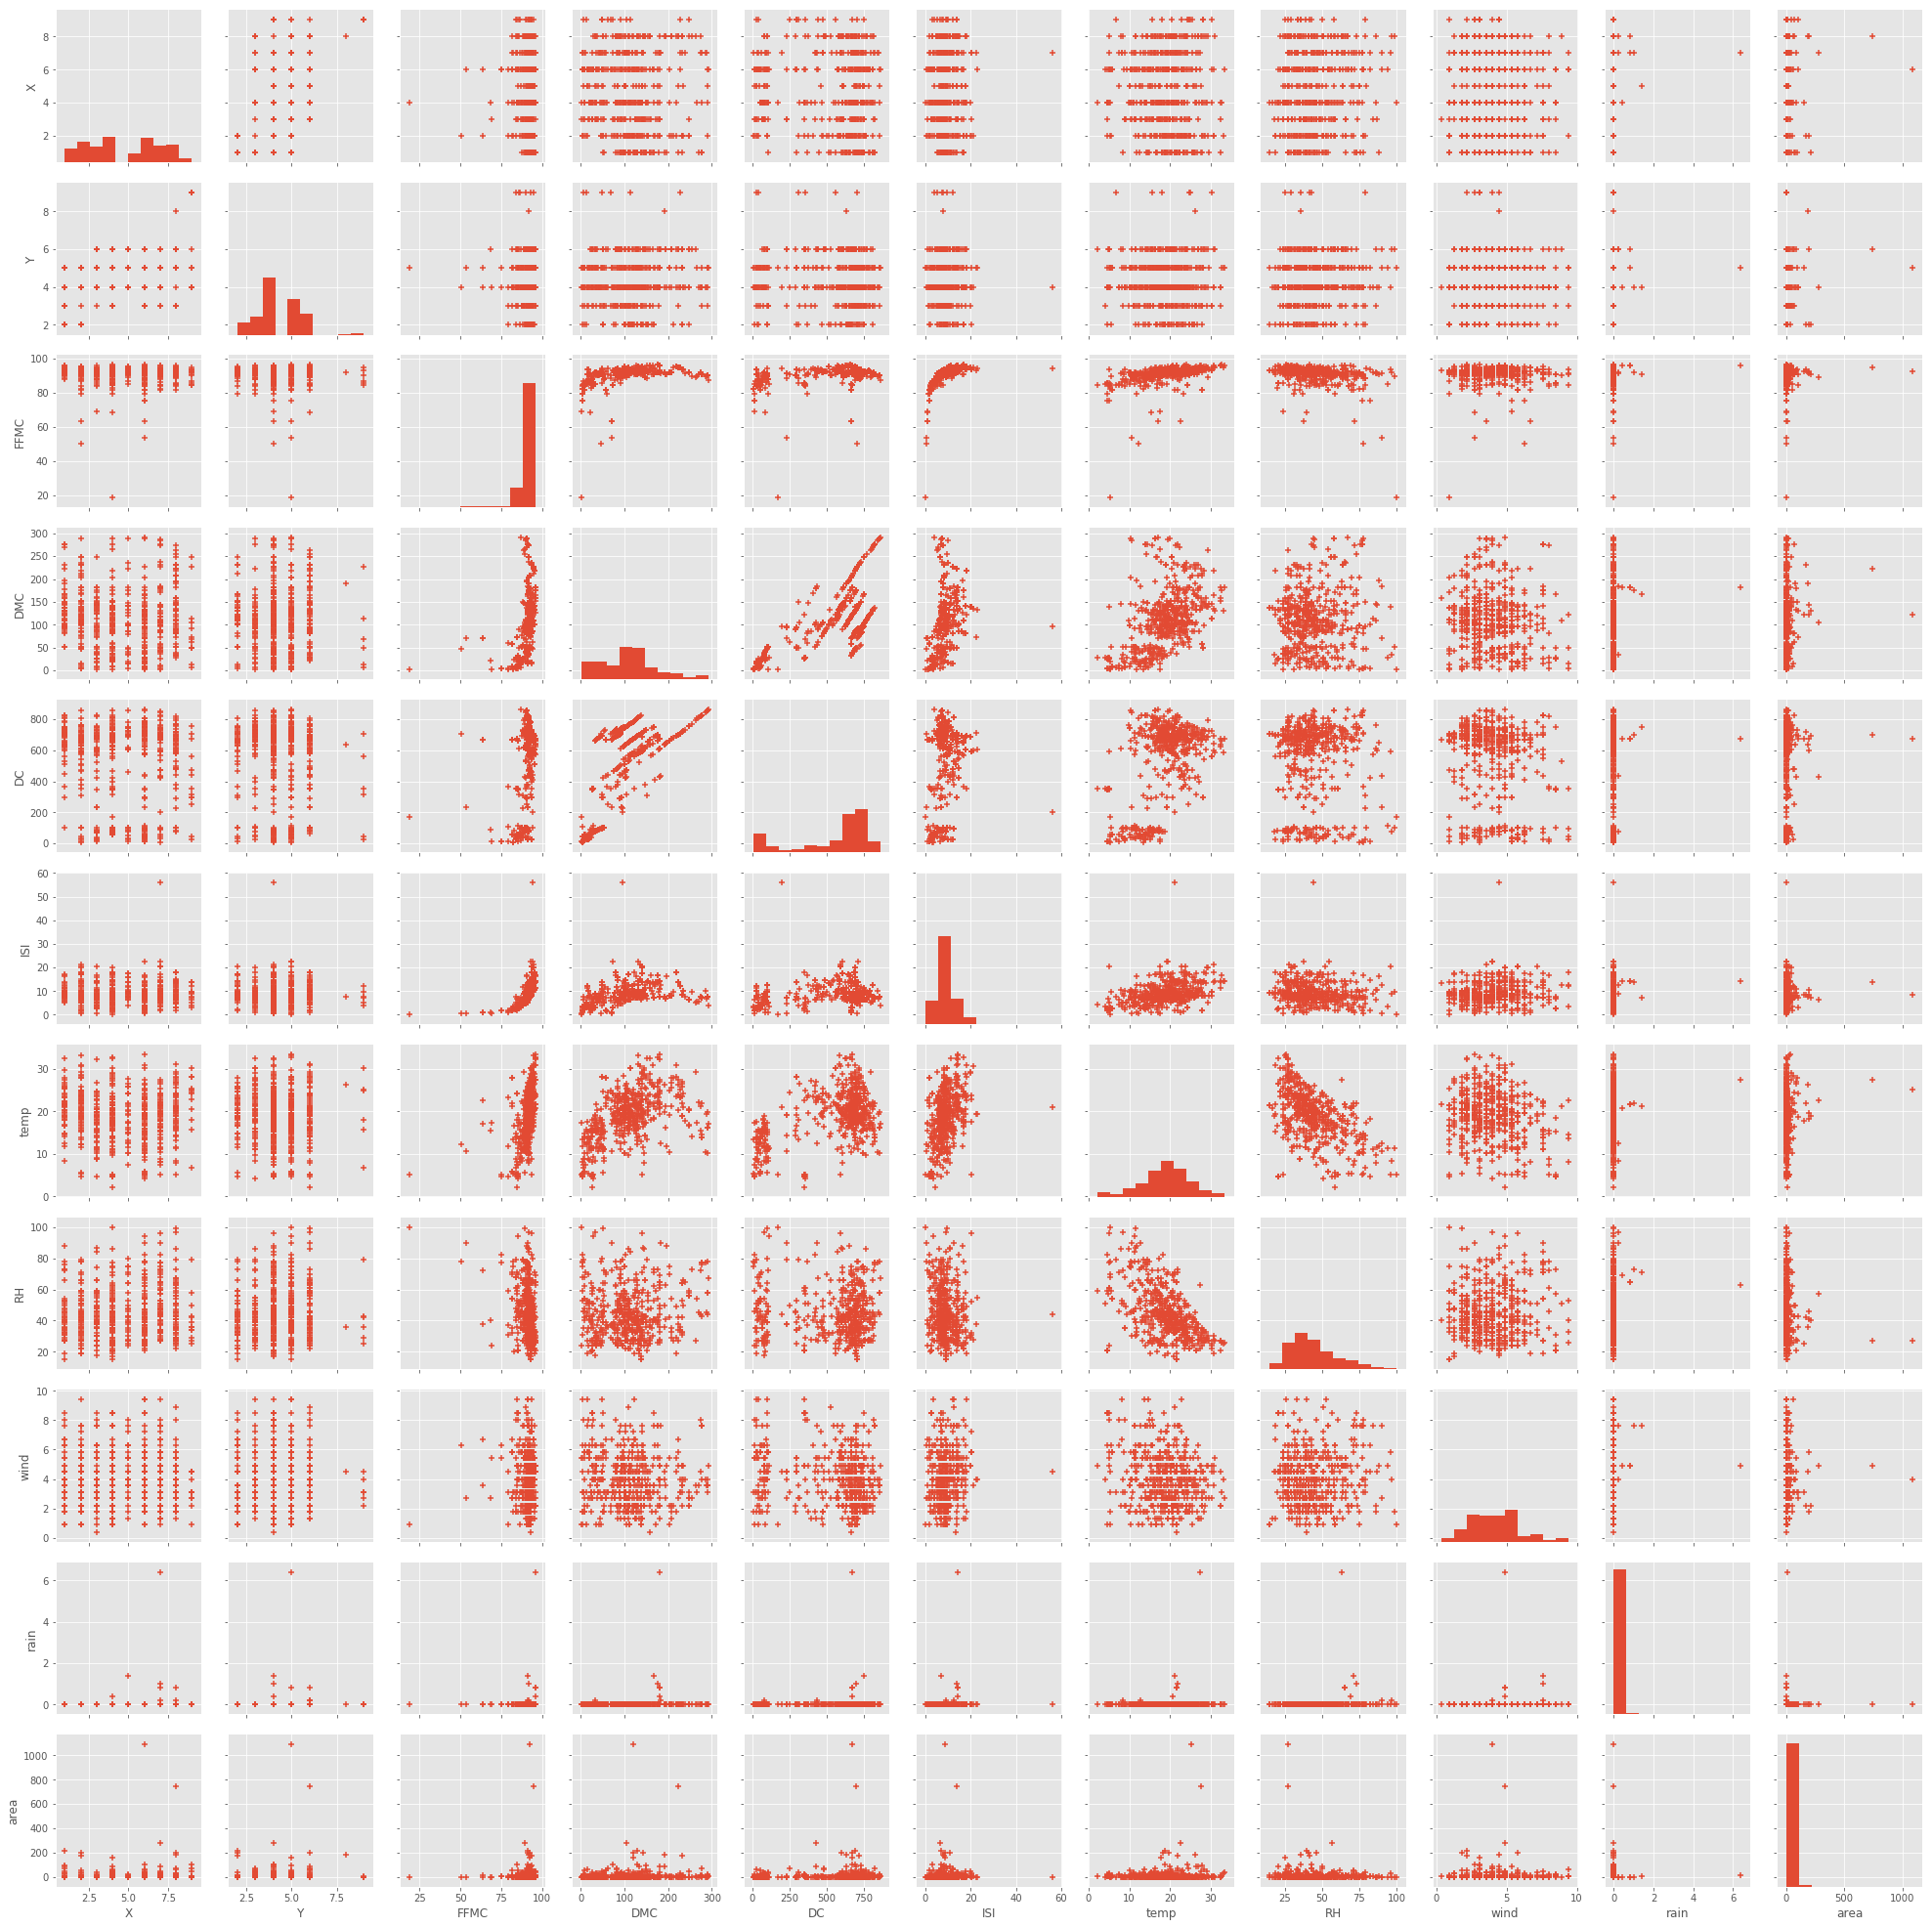

In [8]:
sns.pairplot(fire_df, markers='+')

### Dataset Cleaning

In [9]:
# converting categorical variables into numerical values
label = LabelEncoder()
fire_df.month = label.fit_transform(fire_df.month)
fire_df.day = label.fit_transform(fire_df.day)

In [10]:
fire_df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,7,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,10,5,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,10,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,7,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,7,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [11]:
fire_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 517 entries, 0 to 516
Data columns (total 13 columns):
X        517 non-null int64
Y        517 non-null int64
month    517 non-null int64
day      517 non-null int64
FFMC     517 non-null float64
DMC      517 non-null float64
DC       517 non-null float64
ISI      517 non-null float64
temp     517 non-null float64
RH       517 non-null int64
wind     517 non-null float64
rain     517 non-null float64
area     517 non-null float64
dtypes: float64(8), int64(5)
memory usage: 76.5 KB


In [12]:
fireX = fire_df.drop(["area"], axis=1) # X = all columns excluding the response
print(fireX.shape)

fireY = fire_df.area # Y = response (area column)
print(fireY.shape)

# split the training and test data
X_train, X_test, y_train, y_test = train_test_split(fireX, fireY, test_size = 0.3, random_state = 42) # for reproducibility

(517, 12)
(517,)


## Model I: Multiple Linear Regression

In [13]:
xcolumns = fireX.iloc[0:0, :]
print(xcolumns)

Empty DataFrame
Columns: [X, Y, month, day, FFMC, DMC, DC, ISI, temp, RH, wind, rain]
Index: []


In [14]:
smf_regr = 'area ~ '

xcols = ['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

for i in xcols[:-1]:
    # script to create multiple linear regression formula for statmodels
    smf_regr += '{} + '.format(i)
smf_regr += xcols[-1]

print(smf_regr)

area ~ X + Y + month + day + FFMC + DMC + DC + ISI + temp + RH + wind + rain


In [15]:
# statsmodels -- ordinary least squares without any interaction term
# try to fit the model to all the data
est = smf.ols(smf_regr, fire_df).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-11.5006,63.324,-0.182,0.856,-135.912,112.911
X,1.8812,1.450,1.298,0.195,-0.967,4.729
Y,0.5268,2.740,0.192,0.848,-4.856,5.910
month,0.9733,0.776,1.254,0.210,-0.551,2.498
day,0.4995,1.497,0.334,0.739,-2.442,3.441
FFMC,-0.1074,0.664,-0.162,0.872,-1.411,1.197
DMC,0.1098,0.072,1.524,0.128,-0.032,0.251
DC,-0.0146,0.019,-0.779,0.437,-0.052,0.022
ISI,-0.6108,0.779,-0.784,0.433,-2.141,0.920
temp,0.9801,0.802,1.222,0.222,-0.596,2.556


In this model where we consider all the input features for regression, some of the features have positive coefficients while others have negative. The p-values are rather high for all the input features.

In [16]:
est.summary().tables[0]

Dep. Variable:,area,R-squared:,0.025
Model:,OLS,Adj. R-squared:,0.002
Method:,Least Squares,F-statistic:,1.065
Date:,"Sat, 12 May 2018",Prob (F-statistic):,0.388
Time:,19:18:46,Log-Likelihood:,-2874.0
No. Observations:,517,AIC:,5774.
Df Residuals:,504,BIC:,5829.
Df Model:,12,,
Covariance Type:,nonrobust,,


A good model will have an F-statistic much greater than 1. The F-statistic for this model(when all the input features are considered) is low, i.e, close to 1. An R-squared statistic near 0 indicates that the regression did not explain much of the variability in the response; this might occur because the linear model is wrong, or the inherent error(variance) is high, or both.

In [17]:
print('Residual Sum of Squares =', est.mse_resid)

Residual Sum of Squares = 4045.97315219


### Feature Selection: Backward Step-wise
#### Metric considered: F-statistic

In [18]:
# Backward selection for Advertising dataset -- a modification of the Forward Selection given at: https://planspace.org/20150423-forward_selection_with_statsmodels/

def backward_selected(data, response):
    """Linear model designed by backward selection.
    Parameters:
    -----------
    data : pandas dataframe (fire_df)
    response: string, name of response column in fire_df2 ("area")
    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
    with an intercept
    selected by backward selection
    evaluated by F-statistic
    """
    
    # in this algorithm, we start with all the values and begin to eliminate features progressively
    remaining = list(data.columns) # initializing the list 'remaining' with a set of the unique columns (fields) of the dataset
    remaining.remove(response) # the output/response field is removed from the list of predictors ("remaining")
    
    selected = [] # list initialized to progressively add best features

    # create the formula to calculate the OLS of all data first (to evaluate Rsquare-value)
    formula = "{} ~ {} + 1".format(response, ' + '.join(remaining))
    
    total_score = smf.ols(formula, data).fit().fvalue
    print('F-statistic with all the features =', total_score, '\n')

    for candidate in remaining:
        backup = remaining[:] # keep the original list of predictors intact, and use a backup list
        backup.remove(candidate) # test for Rsqr-value by removing each candidate

        formula = "{} ~ {} + 1".format(response, ' + '.join(backup))
        #print()
        #print(formula)

        score = smf.ols(formula, data).fit().fvalue # the rsquared_adj() method is specially to obtain the Rsqr-value
        print(score)
        if score > total_score:
            total_score = score # total score get assigned the new value of the highest found Rsqr-value
            remaining.remove(candidate) # only features responsible for this best fit are kept
    
    formula = "{} ~ {} + 1".format(response, ' + '.join(remaining))
    model = smf.ols(formula, data).fit() # model.formula
    return model

# call the function to perform feature selection on the forest fire dataset
b_model = backward_selected(fire_df, 'area') # data = dataset, response = output 

print('\nFinal F-statistic for the model with selected features =', '{:3.10f}'.format(b_model.fvalue))
print('\nOriginal feature set: \n', smf_regr)
print('\nOptimized feature set: \n', b_model.model.formula)

F-statistic with all the features = 1.06472438483 

1.00705467957
1.16036964164
1.266888283
1.13941624267
1.33941934275
1.36792604734
1.46467104637

Final F-statistic for the model with selected features = 1.4646710464

Original feature set: 
 area ~ X + Y + month + day + FFMC + DMC + DC + ISI + temp + RH + wind + rain

Optimized feature set: 
 area ~ X + month + FFMC + DMC + ISI + RH + rain + 1


In [19]:
est_rsqr = smf.ols(b_model.model.formula, fire_df).fit()
est_rsqr.summary().tables[0]

Dep. Variable:,area,R-squared:,0.020
Model:,OLS,Adj. R-squared:,0.006
Method:,Least Squares,F-statistic:,1.465
Date:,"Sat, 12 May 2018",Prob (F-statistic):,0.177
Time:,19:18:46,Log-Likelihood:,-2875.3
No. Observations:,517,AIC:,5767.
Df Residuals:,509,BIC:,5801.
Df Model:,7,,
Covariance Type:,nonrobust,,


F-statistic of the final model is higher than the original model.

In [20]:
print('Residual Sum of Squares =', est_rsqr.mse_resid)

Residual Sum of Squares = 4026.68033268


## Model II : kNN

Original feature set: 
 area ~  Y  + day  + DC +  + temp +  + wind + 

Optimized feature set: 
 area ~ X + month + FFMC + DMC + ISI + RH + rain + 1

In [21]:
fireX = fire_df.drop(["area"], axis=1) # X = all columns excluding the response
print(fireX.shape)

fireY = fire_df.area # Y = response (area column)
print(fireY.shape)

# split the training and test data
X_train, X_test, y_train, y_test = train_test_split(fireX, fireY, test_size = 0.3, random_state = 42) # for reproducibility

(517, 12)
(517,)


In [22]:
from sklearn.neighbors import KNeighborsRegressor

# Creating odd list of K for KNN
myList = list(range(1,50))

# Subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# Empty list that will hold cv scores
MSE = []

#Find the best k
for k in neighbors:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_test_pred = knn.predict(X_test)
    scores = mean_squared_error(y_test, y_test_pred)
    MSE.append(scores)

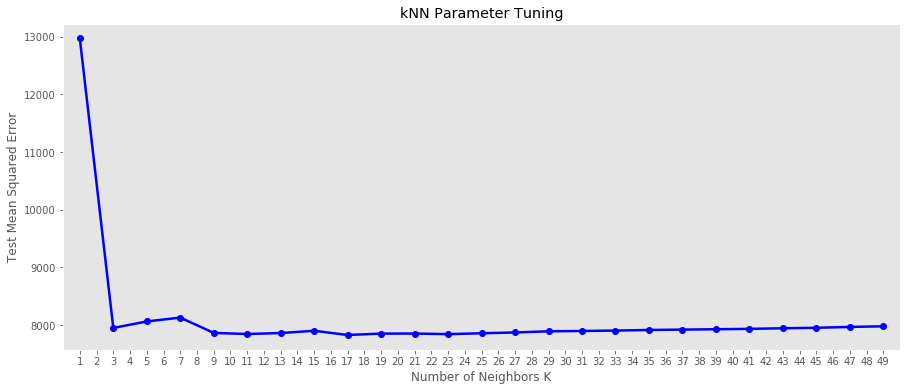

The optimal number of neighbors is 17
Best Test MSE =  7826.06492685


In [23]:
# Plot misclassification error vs k
plt.figure(figsize=(15,6))
plt.plot(neighbors, MSE, 'b-o', linewidth =2.5)
plt.xlim(0, 50)
plt.xticks(range(1,50))
plt.xlabel('Number of Neighbors K')
plt.ylabel('Test Mean Squared Error')
plt.title('kNN Parameter Tuning')
plt.grid()
plt.show()

# # Determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print ("The optimal number of neighbors is %d" % optimal_k)
print("Best Test MSE = ", min(MSE))

## Model III: Lasso Regression

In [24]:
fireX = fire_df.drop(["area"], axis=1) # X = all columns excluding the response
print(fireX.shape)

fireY = fire_df.area # Y = response (area column)
print(fireY.shape)

# Feature Scaling
scaler = StandardScaler()
fireX_scaled = scaler.fit_transform(fireX)

# split the training and test data
X_train, X_test, y_train, y_test = train_test_split(fireX_scaled, fireY, test_size = 0.3, random_state = 42) # for reproducibility

(517, 12)
(517,)


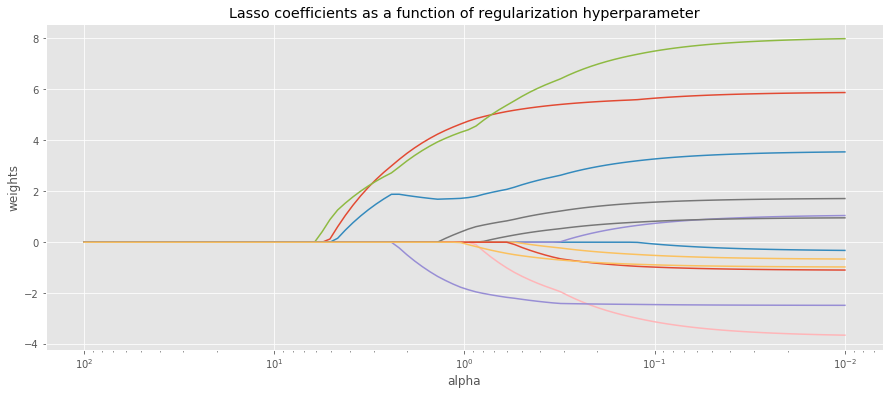

In [25]:
alphas = 10**np.linspace(2,-2,100)*0.5

lasso = Lasso()
coefs = []

for a in alphas*2:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
# labels = ['X' ,'Y' ,'month','day ','FFMC' ,'DMC' ,'DC','ISI' ,'temp','RH','wind', 'rain']
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
# plt.legend()
plt.title('Lasso coefficients as a function of regularization hyperparameter')
plt.gcf().set_size_inches(15,6)

In [26]:
lassocv = LassoCV(alphas=None, cv=10)
lassocv.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [27]:
print('Best alpha (Lasso) =',lassocv.alpha_)
print('Test MSE =',mean_squared_error(y_test, lassocv.predict(X_test)))

Best alpha (Lasso) = 1.71868752562
Test MSE = 7936.52990235


In [28]:
# Best Lasso Coefficients
pd.Series(lassocv.coef_, index=fireX.columns)

X        3.837107
Y        0.000000
month   -0.000000
day      0.000000
FFMC     0.000000
DMC      3.536034
DC      -0.000000
ISI      0.000000
temp     1.767039
RH      -0.885794
wind     0.000000
rain    -0.000000
dtype: float64

## Model IV: Ridge Regression

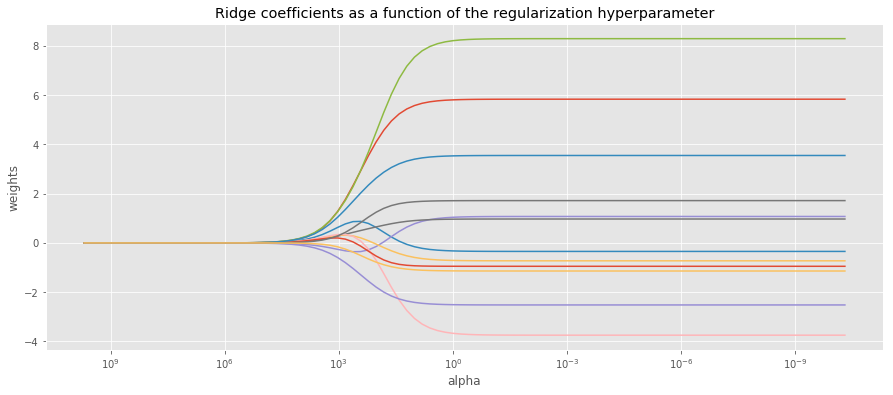

In [29]:
alphas = 10**np.linspace(10,-10,100)*0.5

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X_train), y_train)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization hyperparameter');
plt.gcf().set_size_inches(15,6)

In [30]:
ridgecv = RidgeCV(alphas=alphas, cv=10)
ridgecv.fit(scale(X_train), y_train)

RidgeCV(alphas=array([  5.00000e+09,   3.14015e+09, ...,   7.96141e-11,   5.00000e-11]),
    cv=10, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

In [31]:
ridgecv.alpha_

1715.2346431574597

In [32]:
print('Test MSE =',mean_squared_error(y_test, ridgecv.predict(X_test)))

Test MSE = 7945.21888668


In [33]:
#Best Ridge Coefficients
pd.Series(ridge.coef_, index=fireX.columns)

X        5.835932
Y       -0.344120
month    1.075099
day      0.971851
FFMC    -0.725321
DMC      8.293224
DC      -3.744169
ISI     -0.947774
temp     3.550765
RH      -2.517020
wind     1.718755
rain    -1.138975
dtype: float64